# Spotify Recommendation Model
 This notebook file includes code to:
1. Import required toolboxes
2. Connect to a spotify dev account
3. Organize and pre-process data from provided playlists
4. Build and train and neural network regression model
5. Generate song reccommendations and filter them through model
6. Upload model-filtered song recommendations to a provided spotify playlist

To run this notebook you will need a spotify dev account.  To create one, go to this link and setup an account: https://developer.spotify.com/dashboard/

> Once you have a dev account, go to the dashboard tab and create an app.  Next navigate to your app and locate your Client ID and Client ID Secret.  Copy these two client codes into the notebook code cell below labeld "Authorization".  Next go to your spotify dev project and click "Edit Settings" and under the "Redirect URL" section, place your desired redirect url (ie: https://www.google.com/) for authorization and select save.  Place your redirect url into notebook code cell below "Authorization".

If you are running this code on google colab:
1. Use Chrome as the web browser
2. Change the Runtime type to use a GPU - select Runtime at the top, change runtime type,  select GPU under hardware accelerator



# Imports

In [ ]:
# General Toolboxes
import numpy as np
from numpy import argmax
import pandas as pd
from collections import Counter
from datetime import datetime
import os
import itertools
import math
import collections

# Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
!pip install ipyplot
!pip install jupyter-dash
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
import seaborn as sns
import matplotlib.pyplot as plt

# Neural Network
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.activations import relu, sigmoid, softmax, tanh, selu, elu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
!pip install tensorflow_addons
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import l2, l1
from tensorboard.plugins.hparams import api as hp
!pip install keras-tuner
import kerastuner as kt
!pip install tensorflow_addons
import tensorflow_addons as tfa
!pip install scikeras[tensorflow]
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras_tuner

# Spotify
!pip install spotipy
import spotipy
import spotipy.util as util

# SkLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import warnings 
warnings.filterwarnings("ignore")

#Restart the runtime!
Click on "Runtime" in the menu bar, and select "Restart runtime" from the dropdown menu.<br>
Next re-run the first import cell above.

* The spotipy toolbox requires the runtime to be restarted.

# Authorization
To authenticate your connection to Spotify, click on the link after running this code, and paste the redirected URL into the box.

In [ ]:
#@title Spotify Developer Credentials { run: "auto", vertical-output: true, display-mode: "form" }
SPOTIFY_CLIENT_ID = "" #@param {type:"string"}
SPOTIFY_CLIENT_SECRET = "" #@param {type:"string"}
SPOTIFY_REDIRECT_URI = 'https://www.google.com/'
SCOPE = "playlist-modify-public playlist-read-collaborative playlist-modify-private"
assert len(SPOTIFY_CLIENT_ID)>0, 'Please provide a spotify client id'
assert len(SPOTIFY_CLIENT_SECRET)>0, 'Please provide a spotify client secret code'

sp = spotipy.Spotify(
    auth_manager=spotipy.SpotifyOAuth(
        client_id=SPOTIFY_CLIENT_ID,
        client_secret=SPOTIFY_CLIENT_SECRET,
        redirect_uri=SPOTIFY_REDIRECT_URI,
        scope=SCOPE, open_browser=False),
        requests_timeout=20, retries=10)
form_conn = sp.artist('spotify:artist:3jOstUTkEu2JkjvRdBA5Gu')
print('Authorization Sucessful!')

AssertionError: ignored

## Playlist links:
To get consistent access to your playlists, you need the playlist URI:
1. Open spotify and navigate to your playlist
2. Select the three dots under the playlist and navigate to the share button.
3. Next to the share button mouse over to "Copy Link to Playlist" and press control or command on your keyboard.  "Copy Link to Playlist" will change to "Copy Spotify URI" and click on "Copy Spotify URI".  This link to your playlist will be persitent while the default "Copy Link to Playlist" will change periodically.

Playlists 1-5 will be used as the negative song label when building the model and will be used to remove songs from recommendations.  It is recommended to include a playlist of disliked songs to help the model filter out songs you don't like.  At least one playlist must be specified in playllsts 1-5.

The target playlist will be the positive song label when building the building and will be used to select song recommendations.

An output playlist is required in order for song recommendations to be sent to a playlist.  <strong>It is highly recommended to create a new playlist for the output playlist since songs can be removed in the playlist if specified in the config!</strong>  You will also have to be the creator of the output playlist to add and remove songs from it.<br><br>
Note: the output playlist can not be a Collaborative one since spotify's api doesn't allow automated modification of collaborative playlists.

In [ ]:
#@title Playlist Links { run: "auto", display-mode: "form" }

#@markdown <strong>Playlist 1</strong>
playlist_1_link = "" #@param {type:"string"}
playlist_1_name = "Disliked Songs" #@param {type:"string"}
#@markdown Playlist 2 - optional
playlist_2_link = "" #@param {type:"string"}
playlist_2_name = "" #@param {type:"string"}
#@markdown Playlist 3 - optional
playlist_3_link = "" #@param {type:"string"}
playlist_3_name = "" #@param {type:"string"}
#@markdown Playlist 4 - optional
playlist_4_link = "" #@param {type:"string"}
playlist_4_name = "" #@param {type:"string"}
#@markdown Playlist 5 - optional
playlist_5_link = "" #@param {type:"string"}
playlist_5_name = "" #@param {type:"string"}
#@markdown <strong>Target Playlist</strong>
target_playlist_link = "" #@param {type:"string"}
target_playlist_name = "Liked Songs" #@param {type:"string"}
#@markdown <strong>Output Playlist</strong>
output_playlist_link = "" #@param {type:"string"}

# Assign integer labels to playlists
# playlist_scores = range(len(playlists))

# Convert playlist data into dictionary and filter out blank entries
inp_play_links = [playlist_1_link, playlist_2_link, playlist_3_link, playlist_4_link, playlist_5_link, target_playlist_link]
inp_play_names = [playlist_1_name, playlist_2_name, playlist_3_name, playlist_4_name, playlist_5_name, target_playlist_name]
count = 1
playlists = collections.OrderedDict()
assert len(inp_play_links[0]) > 0, 'Please provide a spotify playlist link for slot Playlist 1'
assert len(target_playlist_link)>0, 'Please provide a target spotify playlist link for model predictions'
assert len(output_playlist_link)>0, 'Please provide an output playlist link to store song recommendations'
for i in range(len(inp_play_links)):
  if len(inp_play_links[i]) > 0:
    if len(inp_play_names[i])==0:
      name = f'playlist {count}'
    else:
      name = inp_play_names[i]
    count +=1
    assert inp_play_links[i][0]=='s', f'provided playlist: {inp_play_links[i]} \
      is not a spotify URI link.  Make sure to double check how to get playlist link in instructions'
    playlists[name] = inp_play_links[i]

playlist_scores = range(len(playlists))
# print(playlists)
print('Playlists Successfully Added!')

AssertionError: ignored

# Functions
Run this cell to generate all of the functions used to load, process, model, and to predict songs.
* None of these functions will be called to run in this cell.

In [ ]:
def chunks(lst, n):
      """Yield successive n-sized chunks from lst
      Inputs:
        lst (list): list of items to be split
        n (int): number of splits to make
      Output:
        lst (list): returns list of lists that are broken up into chunks of size n
        """
      for i in range(0, len(lst), n):
          yield lst[i:i + n]
    

def normalize_data(data, use_max=None, sav_max=False):
    ''' Normalizes a list of data to be values from 0-1.  Uses a max value if 
        provided
    Input:
      data (list): list of data points
      use_max (float): if specified, uses provided max value
      sav_max (bool): if True, save outputs data max.
    Output:-
      norm_data (list): normalized from 0 - 1
      norm_data (float): calculated maximum data point
      '''
    if use_max:
      data_max = use_max
    else:
      data_max = np.max(data)
    norm_data = (data - np.min(data)) / (data_max - np.min(data))
    if sav_max:
      return norm_data, data_max
    else:
      return norm_data


def extract_audio_features(df):
  '''Takes in a dataframe generated from extract_artist_info() and adds additional
     columns for audio features from spotify's api for each song in the dataframe
  Input:
    df (DataFrame): Dataframe generated from extract_artist_info
  Output:
    df (DataFrame): merges audio feature columns into input dataframe'''

  song_ids = list(df.song_id.values)
  # Chunk up song ids to lengths of 50
  song_chunks = list(chunks(song_ids, 50))
  song_list=[]
  for sample in song_chunks:
    result = sp.audio_features(sample)
    song_list.extend(result)
  # loop through songs and store audio features in a list of lists
  array_list = []
  for song in song_list:
    row_list = []
    try:
      acoust = song['acousticness']
      dance = song['danceability']
      energy = song['energy']
      instrument = song['instrumentalness']
      key = song['key']
      live = song['liveness']
      loud = song['loudness']
      mode = song['mode']
      speech = song['speechiness']
      tempo = song['tempo']
      time_sig = song['time_signature']
      valence = song['valence']
      row_list.extend([acoust, dance, energy, instrument, key, live, loud, mode,
                       speech, tempo, time_sig, valence])
      array_list.append(row_list)
    except:
      # If audio features can't be extracted from song, add NaN's
      # print(f"Unable to pull audio features from a song with id: {song}")
      row_list.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
                       np.nan, np.nan, np.nan, np.nan, np.nan])
      array_list.append(row_list)
      pass
  # Create audio feature dataframe and merge with input dataframe
  col_nams = ['acoust', 'dance', 'energy', 'instrument', 'key', 'live', 'loud',
              'mode', 'speech', 'tempo', 'time_sig', 'valence']
  df_songs = pd.DataFrame(data=array_list, columns=col_nams)
  df = pd.merge(df, df_songs, left_index=True, right_index=True)
  return df


def extract_artist_info(df):
  '''Takes a dataframe generated from extract_song_contents() and looks up all
     of the artist ids in the dataframe.  A dictionary is created to keep track of
     artist id row location
  Input:
    df (DataFrame): Dataframe generated from extract_song_contents
  Output:
    df (DataFrame): merges artist info and genre columns into input dataframe'''

  # First flatten list of artist id's in df
  nested_artists = list(df.artist_id.values)
  artists = list(itertools.chain(*nested_artists))
  # Partition artists list for artist lookup
  artists_chunks = list(chunks(artists, 50))
  artist_list = []
  for sample in artists_chunks:
    result = sp.artists(sample)
    artist_list.extend(result['artists'])

  # create a dataframe of all artists with their id, name, popularity, and genres
  df_artists=[]
  for artist in artist_list:
    info = []
    artist_id = artist['id']
    artist_name = artist['name']
    artist_genres = artist['genres']
    artist_pop = artist['popularity']
    info.extend([artist_id, artist_name, artist_genres, artist_pop])
    df_artists.append(info)
  df_artists = pd.DataFrame(data=df_artists,
                            columns=['artist_id', 'artist_name', 'artist_genres',
                                     'artist_pop']).drop_duplicates(subset='artist_id')
  df_artists.set_index('artist_id', inplace=True)
  
  # Loop through df and find artist info in df_artists
  artist_genre, artist_pop = [], []
  for row in df.artist_id:
    multiple_art_genres =[]
    sample = df_artists[df_artists.index==row[0]]
    artist_pop.extend([sample.artist_pop[0]])
    if len(row)<=1:
      multiple_art_genres.extend(sample.artist_genres[0])
    # Loop through other artists on the track
    else:
      for id in row:
          sample = df_artists[df_artists.index==id]
          multiple_art_genres.extend(sample.artist_genres[0])
    artist_genre.append(multiple_art_genres)
  # add artist genres and popularity to df_artists
  df['artist_pop'] = artist_pop
  df['genres'] = artist_genre

  return df


def extract_song_contents(raw_song_data, target=None, recommend_data=False):
  ''' Extracts basic song info generated from create_song_df().
      Runs extract_artist_info() and extract_audio_features() functions and merges 
      into a dataframe.
  Input: 
    raw_song_data (list): list of song dictionaries generated from create_song_df()
    target (int): specified int number to add to rating column.  Adds None if not specified
    recommend_data (bool): specifies if raw_song_data was generated through spotify recommendation api, if so, adjusts how the data is indexed
  Output:
    data (DataFrame): dataframe with song info, audio features, and artist info for all songs'''

  data_lst = []
  # Iterate through each item in the list and add song contents to an array
  if target != None:
    col_nams = ['song_id', 'song_nam', 'dur', 'explicit', 
                'pop', 'album_nam', 'album_type', 'release', 'artist_id',
                'artist_nam', 'rating']
  else:
    col_nams = ['song_id', 'song_nam', 'dur', 'explicit', 'pop', 'album_nam',
                'album_type', 'release', 'artist_id', 'artist_nam']
  for i, song in enumerate(raw_song_data):
    try:
      song_info=[]
      # Adjust indexing based on input type.  Recommend data has slighlty different structure
      if recommend_data:
        track = song
      else:
        track = song['track']

      # Get song general info
      song_id = track['id']
      song_nam = track['name']
      dur = track["duration_ms"]
      explicit = int(track['explicit'])
      pop = track['popularity']
      album_nam = track['album']['name']
      album_type = track['album']['album_type']
      release = track['album']['release_date']
      artist_id = [artist['id'] for artist in track['artists']]
      artist_nam = [artist['name'] for artist in track['artists']]
      if target != None:
        rating = target[i]
        song_info.extend([song_id, song_nam, dur, explicit, pop, album_nam,
                          album_type, release, artist_id, artist_nam, rating])
      else:
        song_info.extend([song_id, song_nam, dur, explicit, pop, album_nam, 
                          album_type, release, artist_id, artist_nam])
      data_lst.append(song_info)
    except:
      print('song id is broken')
      pass
  # Convert array to dataframe
  data = pd.DataFrame(data=data_lst, columns=col_nams)
  # Get artist info
  data = extract_artist_info(data)
  # Get Song Audio features
  data = extract_audio_features(data)
  # Drop rows with null values
  data.dropna(inplace=True)

  return data


def create_song_df(playlists, playlist_scores):
  '''Creates a dataframe by pulling from each provided playlist uri.
     Target values will be assigned from each playlist based on their type:
     Good - 2, ok - 1, bad - 0
  Inputs:
    good_pl_uri (string): spotify URI link to good song playlist
    ok_pl_uri (string): spotify URI link to ok song playlist
    bad_pl_uri (string): spotify URI link to bad song playlist
  Output:
    song_info (DataFrame): dataframe contain all song data from each playlist
    which includes a ratings column that specifies which playlist the song came
    from.  Utilizes the extract_song_contents() function to get song data
     '''
  # Initialize empty list to store looked up songs from each playlist
  song_list, raw_song_data, target_lst = [], [], []
  # for playlist, target_var in zip([good_pl_uri, ok_pl_uri, bad_pl_uri], [2, 1, 0]):
  for playlist, target_var in zip(list(playlists.values()), playlist_scores):
    count=0
    # Pull raw song info from paylist
    while True:
      results = sp.playlist_tracks(playlist, limit=50, offset=count)
      data_len = len(results['items'])
      # Stop adding new song once we reach the end of liked song list
      if data_len==0:
        break
      # add raw song list into our total list
      raw_song_data.extend(results['items'])
      target_lst.extend([target_var] * data_len)
      count += 50
  
  # extract key song details from raw_song_data
  song_info = extract_song_contents(raw_song_data, target_lst)
  return song_info


def rand_sel(source_list, length=None):
  '''Creates a random list of values with a random length from a sample list.
     List length can be specified or randomly chosen.  For spotify's recommend
     function, the max seed length is 5.  Putting length above 5 will break the
     code.
  Inputs:
    source_list (list): list of items to be randomly queried from
    length (int): number of items to randomly select from source_list
  Outputs:
    output (list): randomly selected n number of item/s from source_list based
    on specified length'''
  if length==None:
    length = np.random.randint(len(source_list))
  output = list(np.random.choice(source_list, (1,length))[0])
  return output


def encode_genres(df, col_nam, percen_split=90, cat_list=None, out_ohe_keys=False, split_strings=False):
  '''This function will one-hot-encode a specified column in a dataframe.
     Unique values for the specified column will be identified and the top
     n (percent_split) values will be used to one-hot-encode the column's values.
  
    Function can either write or load encoded lists for one-hot-encoding (ohe).
    Values in each column can also be split into individual words for encoding.
    Function will add one-hot-encoded columns to the input dataframe and remove
    the col_nam column from the dataframe.
  Inputs:
    df (DataFrame): Dataframe generated from create_song_df()
    col_nam (string): name of column in dataframe to be encoded
    percen_split (int): percentile value of most common values used for ohe
    cat_list (list): list of pre-specified one-hot-encoder columns to be used.
      If specified, function will use list for encoding
    out_ohe_keys (bool): if True, then output encoded values, else don't output
    split_strings (bool): if True, then split each value in the specified column
      and encode these split values
  Outputs:
    df_merged (DataFrame): Dataframe with ohe columns added and col_nam column
      removed
    ohe_keys (list): generated ohe value names if out_ohe_keys set to True
    '''
  # Check if funciton provided a pre-processed list of features to onehotencode.
  # If so, then assign the list to mlb's classes
  if cat_list:
    mlb = MultiLabelBinarizer(classes=cat_list)
  else:
    # Loop through each song rating category and find ohe
    result_dictionary = {}
    # for rating in [2, 1, 0]:
    for rating in playlist_scores:
      ohe_list=[]
      df_flt = df[df['rating']==rating]
      # generate onehotencode column list from data
      for item in df_flt[col_nam].values:
        if split_strings:
          # split each string by whitespace
          temp_list=[]
          for string in item:
            temp_list.extend(string.split(' '))
          # remove duplicates from temp_list
          temp_list = list(set(temp_list))
          ohe_list.extend(temp_list)
        else:
          ohe_list.extend(item)

      # Create a dictionary of thresholded genre strings
      output = Counter(ohe_list)
      values = list(output.values())
      top_percen = np.percentile(values, percen_split)
      for key, value in output.items():
        if value >= top_percen:
          result_dictionary[key] = value

    ohe_keys = list(result_dictionary.keys())
    mlb = MultiLabelBinarizer(classes=ohe_keys)

  # edit the columns lists's so that they are a list of strings instead of just one string
  edited_col_data=[]
  for item in df[col_nam]:
    if len(item) <2:
      item.extend(['X', 'X'])
    if split_strings:
      # Split each string in list by whitespace
      temp_list=[]
      for string in item:
        temp_list.extend(string.split(' '))
      # Add that row's string list
      edited_col_data.append(temp_list)
    else:
      edited_col_data.append(item)


  df_new = pd.DataFrame(mlb.fit_transform(edited_col_data), columns=mlb.classes_, index=df.index)
  df_merged = pd.merge(df, df_new, left_index=True, right_index=True).drop(columns=col_nam)
  # If outputing the ohe_keys
  if out_ohe_keys:
    return df_merged, ohe_keys
  else:
    return df_merged
  

def get_date_float(input_str):
  '''Convert release date to float with year_number.month percent of year.
     If string format not easily interpretable, then return some value for year and month.
  Input:
    input_str (sting): datetime string
  Output:
    year (int): year specified in input_str
    month (Int): month specified in input_str
    '''
  if len(input_str) > 5:
    try:
      time = datetime.strptime(input_str, '%Y-%m-%d')
      year = time.timetuple()[0]
      month = time.timetuple()[1]
    except:
      year=2021
      month=1
  else:
    try:
      time = datetime.strptime(input_str, '%Y')
      year = time.timetuple()[0]
      month = 1
    except:
      year = 2021
      month = 1
  return year, month


def man_ord_encode(item):
  '''Manual encode album type column with values between 0 and 1
  Input:
    item (string): album string name
  Output:
    out (float): value based on album string name
    '''
  if item.lower() == 'single':
    out = 0.33
  elif item.lower() == 'album':
    out = 0.66
  elif item.lower() == 'compilation':
    out=0.99
  else:
    out=0
  return out


def wrangle(df, load_enc_lists=False,  genre_list=None, artist_list=None,
            g_split=80, a_split=99.9, max_norm_list=None):
  '''Performs dataset preproccessing by encoding artists and genres, translating
     album type to float, dropping irrelevant columns, and manually scaling
    columns.
  Inputs:
    df (DataFrame): dataframe generated from create_song_df()
    load_enc_lists (bool): if True, use ohe value lists to encode genres and
      artist names
    genre_list (list): list of ohe values for song genres
    artist_list (list): list of ohe values for artists
    g_split (int): percentile value to be used for song genre encoding in
      encode_genres()
    a_split (int): percentile value to be used for artist name encoding in
      encode_genres()
    max_norm_list (list): provided list of maxium values for columns that need
      to be normalized
  Outputs:
    df (DataFrame): input dataframe with preprocessing steps performed
    g_keys (list): list of encoded values for genres if load_enc_lists is False
    a_keys (list): list of encoded values for artists if load_enc_lists is False
    max_list (list): list of maximum values from normalized columns if
      load_enc_lists is False
      '''
  # Format date column
  output = df.release.apply(get_date_float)
  year, month = list(map(list, zip(*output)))
  df['release_year'] = [yr + mth for yr, mth in zip(year, month)]

  # Columns to normalize
  cols_to_normalize = ['artist_pop', 'dur', 'pop_x', 'loud', 'time_sig',
                       'key', 'tempo', 'release_year']

  # Encode string columns - specify if you are usually a pre-run list of categories to one hot encode
  if load_enc_lists:
    if g_split <= 100:
      df = encode_genres(df, col_nam='genres', cat_list=genre_list, split_strings=True)
    else:
      df.drop(columns='genres', inplace=True)
    if a_split <= 100:
      df = encode_genres(df, col_nam='artist_nam', cat_list=artist_list)
      df.drop(columns='artist_nam', inplace=True)
    else:
      df.drop(columns='artist_nam', inplace=True)
    # normalize columns using provided max norm values
    for col, norm in zip(cols_to_normalize, max_norm_list):
      df[col] = normalize_data(df[col].values, use_max=norm)
  else:
    # Artist genre
    if g_split <= 100:
      df, g_keys = encode_genres(df, col_nam='genres', percen_split=g_split, split_strings=True, out_ohe_keys=True)
    else:
      g_keys = []
      df.drop(columns='genres', inplace=True)
    # Artist name
    if a_split <= 100:
      df, a_keys = encode_genres(df, col_nam='artist_nam', percen_split=a_split, out_ohe_keys=True)
    else:
      a_keys = []
      df.drop(columns='artist_nam', inplace=True)
    # Normalize columns and save calculated max value per column
    max_norms=[]
    for col in cols_to_normalize:
      df[col], max_val = normalize_data(df[col].values, sav_max=True)
      max_norms.append(max_val)
  
  # Drop unneeded string columns
  cols_to_drop = ['release', 'song_nam', 'album_nam', 'artist_id']
  df.set_index('song_id', inplace=True)
  df.drop(columns=cols_to_drop, inplace=True)
  df.album_type = df.album_type.apply(man_ord_encode)

  if load_enc_lists:
    return df
  else:
    return df, g_keys, a_keys, max_norms


def get_genre_options(df):
  '''Generates genre seed options based on genres present in good playlist.
     Spotify has select amount of available genres used as seeds to generate
     recommendations.
  Inputs:
    df (DataFrame): dataframe generated from create_song_df()
  Outputs:
    avail_genre_seeds (list): list of genre seeds
    '''
  good_genres=[]
  for item in song_traits[song_traits['rating']==playlist_scores[-1]]['genres']:
    good_genres.extend(item)
  genre_opts = sp.recommendation_genre_seeds()['genres']
  avail_genre_seeds = list(set(genre_opts) & set(good_genres))
  return avail_genre_seeds


def rec_batch_size(n_rec):
  '''Generates a list of API call legnths based on n_rec which is the number
     of desired recommendations.  Spotify API has a recommendation of 100 per
     recommendation API call.
  Input:
    n_rec (int): number of desired recommendations
  Output:
    out (list): list of recommendation limit numbers whereby the max is 100 for
    each list
  Example:
    n_rec = 230, output = [[100], [100], [23]]
    '''
  if n_rec <= 100:
    out = [n_rec]
  else:
    num = math.ceil(n_rec / 100)
    out = ([100] * (num - 1))
    last = [n_rec - (num - 1) * 100]
    out.extend(last)
  return out


def get_rec_filter_values(song_traits):
  df_flt = song_traits[song_traits.rating==len(playlist_scores)-1]
  rec_cats = ['acoust', 'dance', 'dur', 'energy', 'instrument', 'live', 'loud',
              'pop', 'speech', 'tempo', 'valence']
  rec_cats_nams = ['acousticness', 'danceability', 'duration_ms', 'energy',
                  'instrumentalness', 'liveness', 'loudness', 'popularity', 
                  'speechiness', 'tempo', 'valence']
  dict_rec_v = {}
  for rec_cat, rec_nam in zip(rec_cats, rec_cats_nams):
    v_min = min(df_flt[rec_cat])
    v_max = max(df_flt[rec_cat])
    v_avg = np.mean(df_flt[rec_cat])
    # Spotify api recquires some values to be integer
    if rec_cat in ['dur', 'pop']:
      v_min, v_max, v_avg = int(v_min), int(v_max), int(v_avg)
    dict_rec_v[f'min_{rec_nam}'] = v_min
    dict_rec_v[f'max_{rec_nam}'] = v_max
    dict_rec_v[f'target_{rec_nam}'] = v_avg

  return dict_rec_v


def recommend_songs(seed_songs=None, seed_artists=None, seed_genres=None,
                    n_rec=100, rec_list=None):
  '''Takes in a song, artist, or genre seed and calls spotify's recommendation
     API call with a length of n_rec recommendations.
     Returns a list of song dictionaries
  Inputs:
    seed_songs (list): list of song_ids to be used for recommendation
    seed_artists (list): list of artist_ids to be used for recommendation
    seed_genres (list): list of genres to be used for recommendation
    n_rec (int): number of recommendations
    rec_list (list): list of dictionaries of generated song recommendations,
      if not provided, then it will be created.  If provided, then list will
      have new song recommendations added to it
  Outputs:
    song_list (list): list of dictionaries of generated song_recommendations
     '''
  # If a list of recommended songs is provided then set it equal to song_list 
  if rec_list:
    song_list=rec_list
  else:
    song_list=[]
  
  # Create api call size list and loop through it
  req_sizes = rec_batch_size(n_rec)
  for batch in req_sizes:
      try:
        results = sp.recommendations(seed_artists=seed_artists,
                                    seed_genres=seed_genres,
                                    seed_tracks=seed_songs, 
                                    limit=batch,
                                    **dict_rec_v)
        song_list.extend(results['tracks'])
      except:
        print('spotify API timed out on requesting recommendations...trying again...')
        try:
          results = sp.recommendations(seed_artists=seed_artists,
                                      seed_genres=seed_genres,
                                      seed_tracks=seed_songs, 
                                      limit=batch,
                                      **dict_rec_v)
          song_list.extend(results['tracks'])
        except:
          print('spotify API timed out again...skipping this recommendation')
          pass
    
  return song_list


def create_rec_song_list(genre_options, genre_size=300, artist_size=100, song_size=100, target_index=None):
  '''Generates a list of recommended songs.  Uses songs and artists in
     playlist_uri and also uses genre seeds in genre_options to generate song
     recommendations.  _size variables specify number of recommendations to make.
     Implements random selection from song and artist lists to create even more
     recommendations using rand_sel().
  Inputs:
    playlist_uri (string): spotify playlist URI to find song and artist ids
    genre_options (list): list of genre seeds options
    genre_size (int): number of genre recommendations for each seed in g_opts
    artist_size (int): number of artist recommendations for each seed in art_opts
    song_size (int): number of song recommendations for each seed in song_opts
  Outputs:
    rec_song_list (list): list of song dictionary recommendations
    '''

  # Get song and artist ids from favorites playlist
  if target_index:
    target_index=target_index
  else:
    target_index = playlist_scores[-1]
  s_ids = list(song_traits[song_traits.rating==target_index].song_id.values)
  a_ids = [row[0] for row in song_traits[song_traits.rating==target_index].artist_id]
  
  # Set song list to be empy to start
  rec_song_list=[]
  print("Recommending Songs")
  song_opts = []
  for i in range(40):
    song_opts.append(rand_sel(s_ids, 1))
    song_opts.append(rand_sel(s_ids, 2))
    song_opts.append(rand_sel(s_ids, 3))
    song_opts.append(rand_sel(s_ids, 4))
    song_opts.append(rand_sel(s_ids, 5))

  for s in song_opts:
    rec_song_list = recommend_songs(seed_songs=s, n_rec=song_size,
                                    rec_list=rec_song_list,)

  print("Recommending Artists")
  # Pick random artist seeds from favorites
  art_opts = []
  for i in range(40):
    art_opts.append(rand_sel(a_ids, 1))
    art_opts.append(rand_sel(a_ids, 2))
    art_opts.append(rand_sel(a_ids, 3))
    art_opts.append(rand_sel(a_ids, 4))
    art_opts.append(rand_sel(a_ids, 5))

  for a in art_opts:
    rec_song_list = recommend_songs(seed_artists=a,
                                    n_rec=artist_size,
                                    rec_list=rec_song_list)

  # Pick random song seeds from favorites
  fav_song_ids=[]
  print("Recommending Genres")
  # Loop through 3 genre options
  g_opts = [rand_sel(genre_options, 1),  # rand index form list
            rand_sel(genre_options, 1), rand_sel(genre_options, 1),
            rand_sel(genre_options, 1), rand_sel(genre_options, 2),
            rand_sel(genre_options, 2), rand_sel(genre_options, 3),
            rand_sel(genre_options, 4), rand_sel(genre_options, 5)]
  for g in g_opts:
    # Create list of song recommendations
    rec_song_list = recommend_songs(seed_genres=g,
                                    n_rec=genre_size,
                                    rec_list=rec_song_list)

  return rec_song_list


def create_rec_df(song_list, df, rec_target_index=-1):
  '''Takes a list of song recommendations and filters them for repeats and 
     inclusion in df and playlist.  Returns a dataframe
  Inputs:
    song_list (list): list of reccomended song dictionaries
    df (DataFrame): dataframe genereated from wrangle()
    playlist_uri (string): playlist string link
  Output:
    df_rec (DataFrame): dataframe of recommended songs to be passed into
      wrangle()
  '''
  df_rec = extract_song_contents(song_list, target=None, recommend_data=True)

  # Filter song_list for duplicates, inclusion in df, and in out playlist
   # Remove duplicates
  df_rec.drop_duplicates(subset='song_id', inplace=True)
  # # Remove songs that are in the liked songs dataframe
  df_rec = df_rec[~df_rec['song_id'].isin(list(df.index.values))]
 
  # Remove recommendations that are already in the output playlist
  p_ids = list(df[df.rating==rec_target_index].index)
  
  df_rec = df_rec[~df_rec['song_id'].isin(p_ids)]
  return df_rec


def gen_predictions(model, df_test, threshold=None):
  '''Takes in a dataframe generated from wrangle() and runs data through model
     to generate predicted ratings for each song.  Songs below provided
     threshold will be removed.
  Inputs:
    model (tensorflow model): neural network model
    df_test (DataFrame): dataframe of recommended songs to be ran through model
    threshold (float): rating threshold to filter songs in df_test
  Output:
    df_song (DataFrame): filtered df_test dataframe with a predicted rating
      for each song
  '''
  # Drop rating column if it exists in df_test or else model can't predict
  if 'rating' in df_test:
    df_test.drop(columns='rating', inplace=True)

  X_rec = df_test.to_numpy()
  rec_pred = model.predict(X_rec)
  df_test['rating'] = rec_pred
  # Set recommendation threshold automatically if not provided
  if threshold == None:
    threshold = playlist_scores[-1] - 0.3
  # Filter dataframe for only positive predictions
  df_test = df_test[df_test.rating > threshold]
  # create list of song ids
  df_song = list(df_test.index.values)
  return df_song


def upload_songs(df_song, playlist_uri, replace_pl_songs=True):
  ''' Uploads songs to provided playlist.  Can optionally override songs in
      playlist with replace_pl_songs=True.
  Inputs:
    df_song (DataFrame): dataframe of recommended songs
    playlist_uri (string): playlist string name to place songs into
    replace_pl_songs (bool): if True, replaces all songs in playlist with new
      songs.  If false, adds new songs to playlist
  Output:
    Modifies songs in provided playlist.  No variables are returned
  '''
  playlist_out_id = sp.playlist(playlist_uri)['id']
  upload_samples = list(chunks(df_song, 100))
  for i, sample in enumerate(upload_samples):
    if replace_pl_songs:
      if i==0:
        # wipe playlist and add first sample
        sp.playlist_replace_items(playlist_out_id, sample)
      else:
        sp.playlist_add_items(playlist_out_id, sample)
    else:
      sp.playlist_add_items(playlist_out_id, sample)


def create_simple_model():
  '''Creates a regression Sequential neural network model that implements 
     early stopping to select the best layer weights.  It also utilizes class
     weights to adjust the calculated accuracy metrics on the training data.
     Sample weights are also implemented to adjust accuracy metrics on
     validation data.
  Inputs:
    X_train, y_train, X_test, y_test, class_weights, val_sample_weights variables
    should be generated before running this function.
  Outputs:
    model (tensorflow model): compiled and fitted neural network model
  '''
  # Remove tensorboard logs
  !rm -rf ./logs/
  # Set Callbacks
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs")
  es = EarlyStopping(
    monitor="val_weighted_pr_auc",
		patience=30,
    mode='max',
		restore_best_weights=True,
		min_delta=0.0001)

  # Build Model
  model = Sequential()
  model.add(Dense(400, input_dim=input_dim, activation='relu'))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(1, activation='tanh'))
  
  pr_auc = tf.keras.metrics.AUC(num_thresholds=1000, curve="PR", name='pr_auc', from_logits=True)
  # Compile and fit model
  model.compile(loss='squared_hinge', optimizer='adam',
                metrics=['accuracy', pr_auc], 
                weighted_metrics=['accuracy', pr_auc])
  
  model.fit(X_train, y_train, validation_data=[X_test, y_test, val_sample_weights], epochs=100,
            batch_size=32, verbose=0, callbacks=[es, tensorboard], class_weight=class_weights)
  return model, tensorboard


def create_complicated_model(optimizer, learning_rate, n_layers, n_layer_1,
                             n_layer_2, n_layer_3, n_layer_4, n_layer_5,
                             reg_type, reg_max, max_norm, activation, p_drop,
                             batch_norm, batch_size):
  # Set optimizer learning rate
  if optimizer == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
      opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

  # Set Weight regularizer
  if reg_type == 'l1':
    kernel_regularizer = l1(reg_max)
  elif reg_type == 'l2':
    kernel_regularizer = l2(reg_max)
  else:
    kernel_regularizer=None
  
  # Adjust batch normalization
  if batch_norm==1:
    use_bias=False
  else:
    use_bias=True

  # Adjust activation initializer if selu
  if activation=='selu':
    kernel_initializer = 'lecun_normal'
  else:
    kernel_initializer = 'he_normal'

  # Set weight value constraint
  kernel_constraint = MaxNorm(max_value=max_norm)
  
    # Create model
  model = Sequential()
  if batch_norm==1:
        model.add(BatchNormalization())
  
  layer_list = [n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5]
  for i in range(n_layers):
    model.add(Dense(layer_list[i],
                    kernel_regularizer=kernel_regularizer,
                    kernel_constraint=kernel_constraint,
                    kernel_initializer=kernel_initializer,
                    use_bias=use_bias))
    if batch_norm==1:
      model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(p_drop))

  pr_auc = tf.keras.metrics.AUC(num_thresholds=1000, curve="PR", name='pr_auc', from_logits=True)
  # Output layer
  model.add(Dense(1, activation='tanh'))
  model.compile(loss='squared_hinge', optimizer=opt,
                metrics=['accuracy', pr_auc], 
                weighted_metrics=['accuracy', pr_auc])
  
  es = EarlyStopping(
    monitor="val_weighted_pr_auc",
		patience=60,
    mode='max',
		restore_best_weights=True,
		min_delta=0.0001)
  !rm -rf ./logs/
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  model.fit(
      x=X_train, y=y_train,
      validation_data=(X_test, y_test, val_sample_weights),
      batch_size=batch_size,
      shuffle=True,
      verbose=0,
      callbacks=[es, tensorboard],
      class_weight=class_weights,
      epochs=500,
      workers=-1
    )

  return model, tensorboard


class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    # Tuning params
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam'])
    lr = hp.Choice("learning_rate", values=[1E-3, 1e-4, 3e-4, 4e-4, 5e-4, 1e-5, 1e-6])
    n_layers = hp.Int('n_layers', min_value=1, max_value=5, step=1)
    reg_type = hp.Choice('reg_type', values=['l1', 'l2', 'none'])
    max_norm = hp.Int('max_norm', min_value=1, max_value=10000, step=10)
    activation = hp.Choice('activation', values=['relu', 'selu', 'elu'])
    p_drop = hp.Float('p_drop', min_value=0.0, max_value=0.9, step=0.05)
    batch_norm = hp.Choice('batch_norm', values=[0, 1])

    # Set optimizer learning rate
    if optimizer == 'adam':
      opt = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        opt = tf.keras.optimizers.Nadam(learning_rate=lr)

    # Adjust batch normalization
    if batch_norm==1:
      use_bias=False
    else:
      use_bias=True

    # Adjust activation initializer if selu
    if activation=='selu':
      kernel_initializer = 'lecun_normal'
    else:
      kernel_initializer = 'he_normal'

    # Set Weight regularizer
    if reg_type == 'l1':
      kernel_regularizer = l1(hp.Float('reg_max', min_value=0.0001, max_value=0.09, step=0.0001))
    elif reg_type == 'l2':
      kernel_regularizer = l2(hp.Float('reg_max', min_value=0.0001, max_value=0.09, step=0.0001))
    else:
      kernel_regularizer=None
    
    # Set weight value constraint
    kernel_constraint = MaxNorm(max_value=max_norm)
    
      # Create model
    model = Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_dim))

    if batch_norm==1:
        model.add(BatchNormalization())
    for i in range(n_layers):
      model.add(Dense(hp.Int(f'n_layer_{i+1}', min_value=20, max_value=3000, step=5),
                      kernel_regularizer=kernel_regularizer,
                      kernel_constraint=kernel_constraint,
                      kernel_initializer=kernel_initializer,
                      use_bias=use_bias))
      if batch_norm==1:
        model.add(BatchNormalization())
      model.add(Activation(activation))
      model.add(Dropout(p_drop))

    pr_auc = tf.keras.metrics.AUC(num_thresholds=1000, curve="PR", name='pr_auc', from_logits=True)
    # Output layer
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='squared_hinge', optimizer=opt,
                  metrics=['accuracy', pr_auc], 
                  weighted_metrics=['accuracy', pr_auc])

    return model


  def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", min_value=10, max_value=180, step=2),
            **kwargs,)


def run_tuning(input_dim, X_train, X_test, y_train, y_test, y, num_iter, tune_metric='accuracy'):
  # Early Stopping
  if tune_metric == 'accuracy':
    metric_nam = 'val_weighted_accuracy'
    direction='max'
  elif tune_metric == 'loss':
    metric_nam = 'val_loss'
    direction='min'
  else:
    metric_nam = 'val_weighted_pr_auc'
    direction='max'

  es = EarlyStopping(
    monitor=metric_nam,
		patience=60,
    mode=direction,
		restore_best_weights=True,
		min_delta=0.0001)
  
  tuner = kt.BayesianOptimization(
			MyHyperModel(),
      objective=kt.Objective(metric_nam, direction=direction),
			max_trials=num_iter,
      num_initial_points=int(0.3 * num_iter),
			seed=42,
			beta=3.5,
			directory='./keras-tuner',
			project_name=str(np.random.choice(range(0,900000)))
      )

	# Tensorboard callback
  !rm -rf ./logs/
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs")
  # Tuner Search
  tuner.search(
		x=X_train, y=y_train,
		validation_data=(X_test, y_test, val_sample_weights),
		shuffle=True,
		verbose=1,
		callbacks=[es, tensorboard],
    class_weight=class_weights,
		epochs=500,
		workers=-1
	)
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  best_model = tuner.get_best_models()[0]

  return best_model, best_hps, tuner, tensorboard


def vis_preds(data, y_data, model, fig_title, pred_songs=False):
  if pred_songs:
    if 'rating' in df_test.columns: df_test.drop(columns='rating', inplace=True)
    out_pred = model.predict(df_test.to_numpy())
    fig = px.histogram(out_pred, nbins=200, title=fig_title)
  else:
    train_pred = model.predict(data)
    cols = list(df.columns)
    cols.remove('rating')
    ac_test = pd.DataFrame(data=data, columns=cols)
    ac_test['rating'] = y_data
    ac_test['pred_rating'] = train_pred
    ac_test.sort_values('rating', ascending=True, inplace=True)
    fig = px.histogram(ac_test, x='pred_rating', color='rating', opacity=0.75,
                       barmode='overlay', nbins=200, title=fig_title)
  return fig.show()


def calc_pred_thresh(percen_split=99):
  if 'rating' in df_test.columns: df_test.drop(columns='rating', inplace=True)
  out_pred = model.predict(df_test.to_numpy())
  threshold = np.percentile(out_pred, percen_split)
  return threshold


# Config - model settings and song recommendations
This code cell can be customized to adjust how your song data is processed, how many song recommendations are created, and how many songs are added to your output playlist.<br>

Data Preparation:
1. genre_split_percentile (Range 0-101) - Default 80 - Percentile to split for most common genres. ie: 80 = top 20% most common genres.  If 101 is specified, then genres will not be included in the data.
2. artist_split_percentile (Range 0-101) - Default 101 - Percentile to split for most common artists. ie: 80 = top 20% most common artists.  If 101 is specified, then artists will not be included in the data.  101 is the default to help prevent overfitting the provided data.

Model Tuning Settings:
1. model_use ('simple', 'complicated', 'tune') - Default 'complicated' - Model selection approach whereby simple impelements a non-tuned neural network model without regularization parameters, complicated will use the model settings specified in the code segment "Tuned-model settings' and train a model with these hyperparameter settings.  tune will run a bayesian tuner with your specified number of iterations and model metric.
2. model_tune_num_iterations (Range 1-300) - Default 25 - Number of models to try if 'tune' is selected for model_use.  Large values (above 50) can result in the tuning process taking several hours.
3. model_tune_metric ('accuracy', 'pr_auc', 'loss') - Default 'pr_auc' - Metric used for model tuning.  pr_auc is weighted area under precision recall curve for the target playlist.  accuracy is the weight accuracy score for target playlist.  loss is the smallest hinge loss.

Recommendation Parameters:
1. n_genre_recs (Range 0-2000) - Default 500 - Number of recommendations generated per group based on genre/s in target playlist
2. n_artist_recs (Range 0-2000) - Default 100 - Number of recommendations generated per group based on artist/s in target playlist
3. n_song_recs (Range 0-2000) - Default 100 - Number of recommendations generated per group based on song/s in target playlist
4. song_threshold ('manual', 'auto') - Default 'auto' - manual will present 3 figures to you showing the prediction classification for the training data, test data, and recommended song data.  Pick a threshold that best separates the positive class (red) from the negative class (blue), all values above threshold will be added to your output playlist.  auto will select the 99th percentile value of predicted song rating to include in your target playlist, which is typically around 100 songs.
5. replace_out_playlist_songs (Range True, False) - Default False - Don't replace songs in output playlist and append song recommendations to the playlist, True - replace all songs in the playlist with song recommendations



In [ ]:
#@title Config { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown Pre-Processing
genre_split_percentile = 80 #@param {type:"slider", min:0, max:101, step:1}
artist_split_percentile = 101 #@param {type:"slider", min:0, max:101, step:1}
#@markdown Model Tuning
model_use = "complicated" #@param ["simple", "complicated", "tune"]
model_tune_num_iterations = 50 #@param {type:"slider", min:1, max:100, step:1}
model_tune_metric = "pr_auc" #@param ["pr_auc", "accuracy"]
#@markdown Song Recommendations
n_genre_recs = 500 #@param {type:"slider", min:0, max:600, step:25}
n_artist_recs = 100 #@param {type:"slider", min:0, max:300, step:25}
n_song_recs = 100 #@param {type:"slider", min:0, max:300, step:25}
song_threshold = "auto" #@param ["auto", "manual"]
replace_out_playlist_songs = False #@param ["False", "True"] {type:"raw"}

# Warn user that songs will be removed from output playlist
if replace_out_playlist_songs==True:
  print('WARNING: Songs in output playlist will be removed and replaced with new songs!')

# Notify user if model tuning is selected and num of iterations is greater than 50
if (model_use=='tune') & ((model_tune_num_iterations>=50) & (model_tune_num_iterations<75)):
  print('WARNING: Model tuning iterations are 50 or more. The tuning process could take 2 or more hours to complete!')
if (model_use=='tune') & (model_tune_num_iterations>=75):
  print('WARNING: Model tuning iterations are 75 or more. The tuning process could take 4 or more hours to complete!')

### Tuned-model settings

In [ ]:
tuned_model_hyperparams = {
  'activation': 'elu',
  'batch_norm': 1,
  'batch_size': 180,
  'learning_rate': 0.0001,
  'max_norm': 1,
  'n_layer_1': 20,
  'n_layer_2': 20,
  'n_layer_3': 3000,
  'n_layer_4': 3000,
  'n_layer_5': 20,
  'n_layers': 5,
  'optimizer': 'nadam',
  'p_drop': 0.0,
  'reg_max': 0.0001,
  'reg_type': 'l1'}

# Run Functions
This code segment will run all of the above functions and utilizes the parameter values specified in the config segment above.<br>
Running this segment will take around 4 minutes depending on the size of recommendations specified in the config.<br>
The output will be recommended songs added to the output playlist.

### Process Playlist Data and Generate Recommendation Pool

In [ ]:
# Wrangle
print('Pulling Playlist Data and Processing')
song_traits = create_song_df(playlists, playlist_scores)
dict_rec_v = get_rec_filter_values(song_traits)
df, g_keys, a_keys, max_col_vals = wrangle(song_traits, load_enc_lists=False, 
                                           genre_list=None, artist_list=None,
                                           g_split=genre_split_percentile,
                                           a_split=artist_split_percentile)

# Split dataframe
y = np.array([1 if row == len(playlist_scores)-1 else 0 for row in df.rating])
X = df.drop(columns='rating').to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,
                                                    random_state=42, stratify=y,
                                                    shuffle=True)
input_dim = X.shape[1]

# # Create weights variable
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y), y=y)))
sample_weights = dict(zip(playlist_scores, compute_class_weight('balanced', classes=np.unique(y), y=y)))
val_sample_weights = class_weight.compute_sample_weight(sample_weights, y_test)

# Recommend
genre_seed_options = get_genre_options(song_traits)
song_list = create_rec_song_list(genre_seed_options,
                                 genre_size=n_genre_recs,
                                 artist_size=n_artist_recs,
                                song_size=n_song_recs)

print('Processing Recommendations')
# Create dataframe and filter predictions for repeats
df_rec = create_rec_df(song_list, df)

# Wrangle our dataframe
df_test = wrangle(df_rec, load_enc_lists=True, genre_list=g_keys,
                  artist_list=a_keys, max_norm_list=max_col_vals,
                  g_split=genre_split_percentile,
                  a_split=artist_split_percentile)

print('Data Processing Complete!')

### Model and Populate Output Playlist

In [ ]:
# Create model
print('Creating Model')
if model_use == 'tune':
  model, best_hps, tuner, tensorboard = run_tuning(input_dim,
                                X_train, X_test, y_train, y_test, y,
                                model_tune_num_iterations, model_tune_metric)
  print(f"These are tuned model's best hyperparameters.  Make sure to add them to tuned model settings above")
  display(best_hps.values)
elif model_use == 'complicated':
  model, tensorboard = create_complicated_model(**tuned_model_hyperparams)
else:
  model, tensorboard = create_simple_model()  

# Use model to generate song predictions and output a list of songs past a threshold
if song_threshold == 'auto':
  threshold = calc_pred_thresh()
elif song_threshold == 'manual':
  vis_preds(X_train, y_train, model, 'Training Data')
  vis_preds(X_test, y_test, model, 'Validation Data')
  vis_preds(None, None, model, 'Recommended Songs', pred_songs=True)
  print('Use the graphs to select a threshold for recommended songs to include in output playlist')
  threshold = float(input('Enter your threshold here: '))
else:
  print('Specify a valid song_threshold type in the config above...using auto...')
  threshold = calc_pred_thresh()

out_song_list = gen_predictions(model, df_test, threshold=threshold)

# Add songs to playlist
print(f"{len(out_song_list)} songs were added to the playlist")
upload_songs(out_song_list, playlist_uri=output_playlist_link, replace_pl_songs=replace_out_playlist_songs)
print("Playlist Updated Successfully!")

## Extra Code Segment to manually adjust song threshold
Use this code segment if you want to try out different manual thresholds for your song predictions

In [ ]:
# Show model prediction visualizations
vis_preds(X_train, y_train, model, 'Training Data')
vis_preds(X_test, y_test, model, 'Validation Data')
vis_preds(None, None, model, 'Recommended Songs', pred_songs=True)
print('Use the graphs to select a threshold for recommended songs to include in output playlist')
threshold = float(input('Enter your threshold here: '))

# Apply threshold and populate output playlist
out_song_list = gen_predictions(model, df_test, threshold=threshold)
print(f"{len(out_song_list)} songs were added to the playlist")
upload_songs(out_song_list, playlist_uri=output_playlist_link, replace_pl_songs=True)
print("Playlist Updated Successfully!")

# Feature exploration
These code segments visualize and explore aspects of input song data. <br>

The below code segment generates several histograms for various song traits and color codes the plots based on the playlist.  In these interactive plots, playlists can be hidden by clickon on them in the legend for each plot.

In [ ]:
categories = ['dur', 'pop_x', 'album_type', 'artist_pop', 'acoust', 'dance_x',
              'energy', 'instrument', 'key', 'live', 'loud', 'mode', 'speech',
              'tempo', 'time_sig', 'valence', 'release_year']
cat_names = ['song duration', 'song popularity', 'album type',
             'artist popularity', 'acousticness', 'danceability', 'energy',
             'instrumentalness', 'song key', 'liveness', 'loudness', 'mode',
             'speech', 'tempo', 'time signature', 'valence', 'release year']
playlist_names = list(playlists.keys())             

# Create Dashboard
def set_layout(fig, fig_title=None, l=0, r=0, t=45, b=0):
    fig.update_layout(
        showlegend=True,
        legend={
            'orientation': "h",
            'yanchor': "bottom",
            'y': -0.2,
            'xanchor': "center",
            'x': 0.5,
        },
        margin={'t': t, 'r': r, 'l': l, 'b': b},
        xaxis={'anchor': 'y', 'domain': [0.0, 1.0]},
        yaxis={'anchor': 'x', 'domain': [0.0, 1.0]},
        height=500,
        barmode='overlay',
        title= fig_title.title()
    )
    fig.update_xaxes(title_text = f"Normalized {fig_title}")
    fig.update_yaxes(title_text = "Count")
    fig.update_traces(opacity=0.75)


app = JupyterDash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

# Generate graph data for app and add elements to a list
app_graphs, count = [], 0
for cat, cat_nam in zip(categories, cat_names):
  locals()[cat] = go.Figure()
  for i, val in zip(range(len(playlists)), playlist_scores):
    locals()[cat].add_trace(go.Histogram(x=df[df.rating==val][cat].values,
                                        name=f'{playlist_names[i]}'))
  set_layout(locals()[cat], fig_title=cat_nam)

  # Add graph to app_graphs
  app_graphs.append(
      html.Div(
          [dcc.Graph(id=cat_nam, figure=locals()[cat])],
          style={'width': '49%', 'display': 'inline-block', 'padding': '0px 0px', 'margin':'0% 0.5% 0px 0%'}
          ))
  # Move to next row if on column 3
  if count == 1:
    app_graphs.append(html.Br())
    count=0
  else:
    count += 1

app.layout = html.Div(app_graphs)

print('Dashboard loading ~ 2 minutes')
app.run_server(mode='inline', height=1500, host='127.0.0.1', port='8050')

### Scater Polar Plot of Song Features
This plot visualizes the average values of song features for each playlist.  All feature values are normalized from 0 to 1 based on the minimum and maximum values from the input data.

This plot helps to visualize all of the song features together and to compare/contrast their values between playlists.

In [ ]:
# Scatter Polar
df_polar = df[categories + ['rating']]
fig = go.Figure()
for i, val in zip(range(len(playlists)), playlist_scores):
  name = playlist_names[i]
  values = list(df_polar[df_polar.rating==val].mean(axis=0).drop('rating'))
  fig.add_trace(go.Scatterpolar(
          r = values,
          theta = cat_names,
          name = name,
          fill='toself',
          opacity=0.75
      ))
fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,
    margin=dict(
        l=100,
        r=200,
        b=100,
        t=100,
        pad=4
    ),
    title='Song Features by Playlist')
fig.show()

In [ ]:
# Scatter Polar Predictions
df_polar = df[categories]
df_polar['rating'] = y
names = ['Non-Target Songs', 'Target Songs']
fig = go.Figure()
for i in np.unique(y):
  values = list(df_polar[df_polar.rating==i].mean(axis=0).drop('rating'))
  fig.add_trace(go.Scatterpolar(
          r = values,
          theta = cat_names,
          name = names[i],
          fill='toself',
          opacity=0.75
      ))
  
# If recommendations are generated and model is created, add thresholded
# song data to scater polar
try:
  df_polar = df_test[categories]
  avg_overall_values = list(df_polar.mean(axis=0))
  if 'rating' in df_test.columns: df_test.drop(columns='rating', inplace=True)
  X_rec = model.predict(df_test.to_numpy())
  thresh_X_rec = [1 if row > threshold else 0 for row in X_rec]
  df_polar['rating'] = thresh_X_rec
  # Add values to plot
  names = ['Not-Selected Recommendations', 'Selected Recommendations']
  for i in np.unique(y):
    values = list(df_polar[df_polar.rating==i].mean(axis=0).drop('rating'))
    fig.add_trace(go.Scatterpolar(
            r = values,
            theta = cat_names,
            name = names[i],
            fill='toself',
            opacity=0.75
        ))

# if model or recommendations are not created
except:
  # check if recommendations are created, if so, add them to scatter polar
  try:
    print('Model not created')
    fig.add_trace(go.Scatterpolar(
          r = avg_overall_values,
          theta = cat_names,
          name = "All Song Recommendations",
          fill='toself',
          opacity=0.75
      ))

  # if recommendations aren't created, just print a statement
  except:
    print('Recommendations not generated')

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,
    margin=dict(
        l=100,
        r=200,
        b=100,
        t=100,
        pad=4
    ),
    title='Song Features')
fig.show()

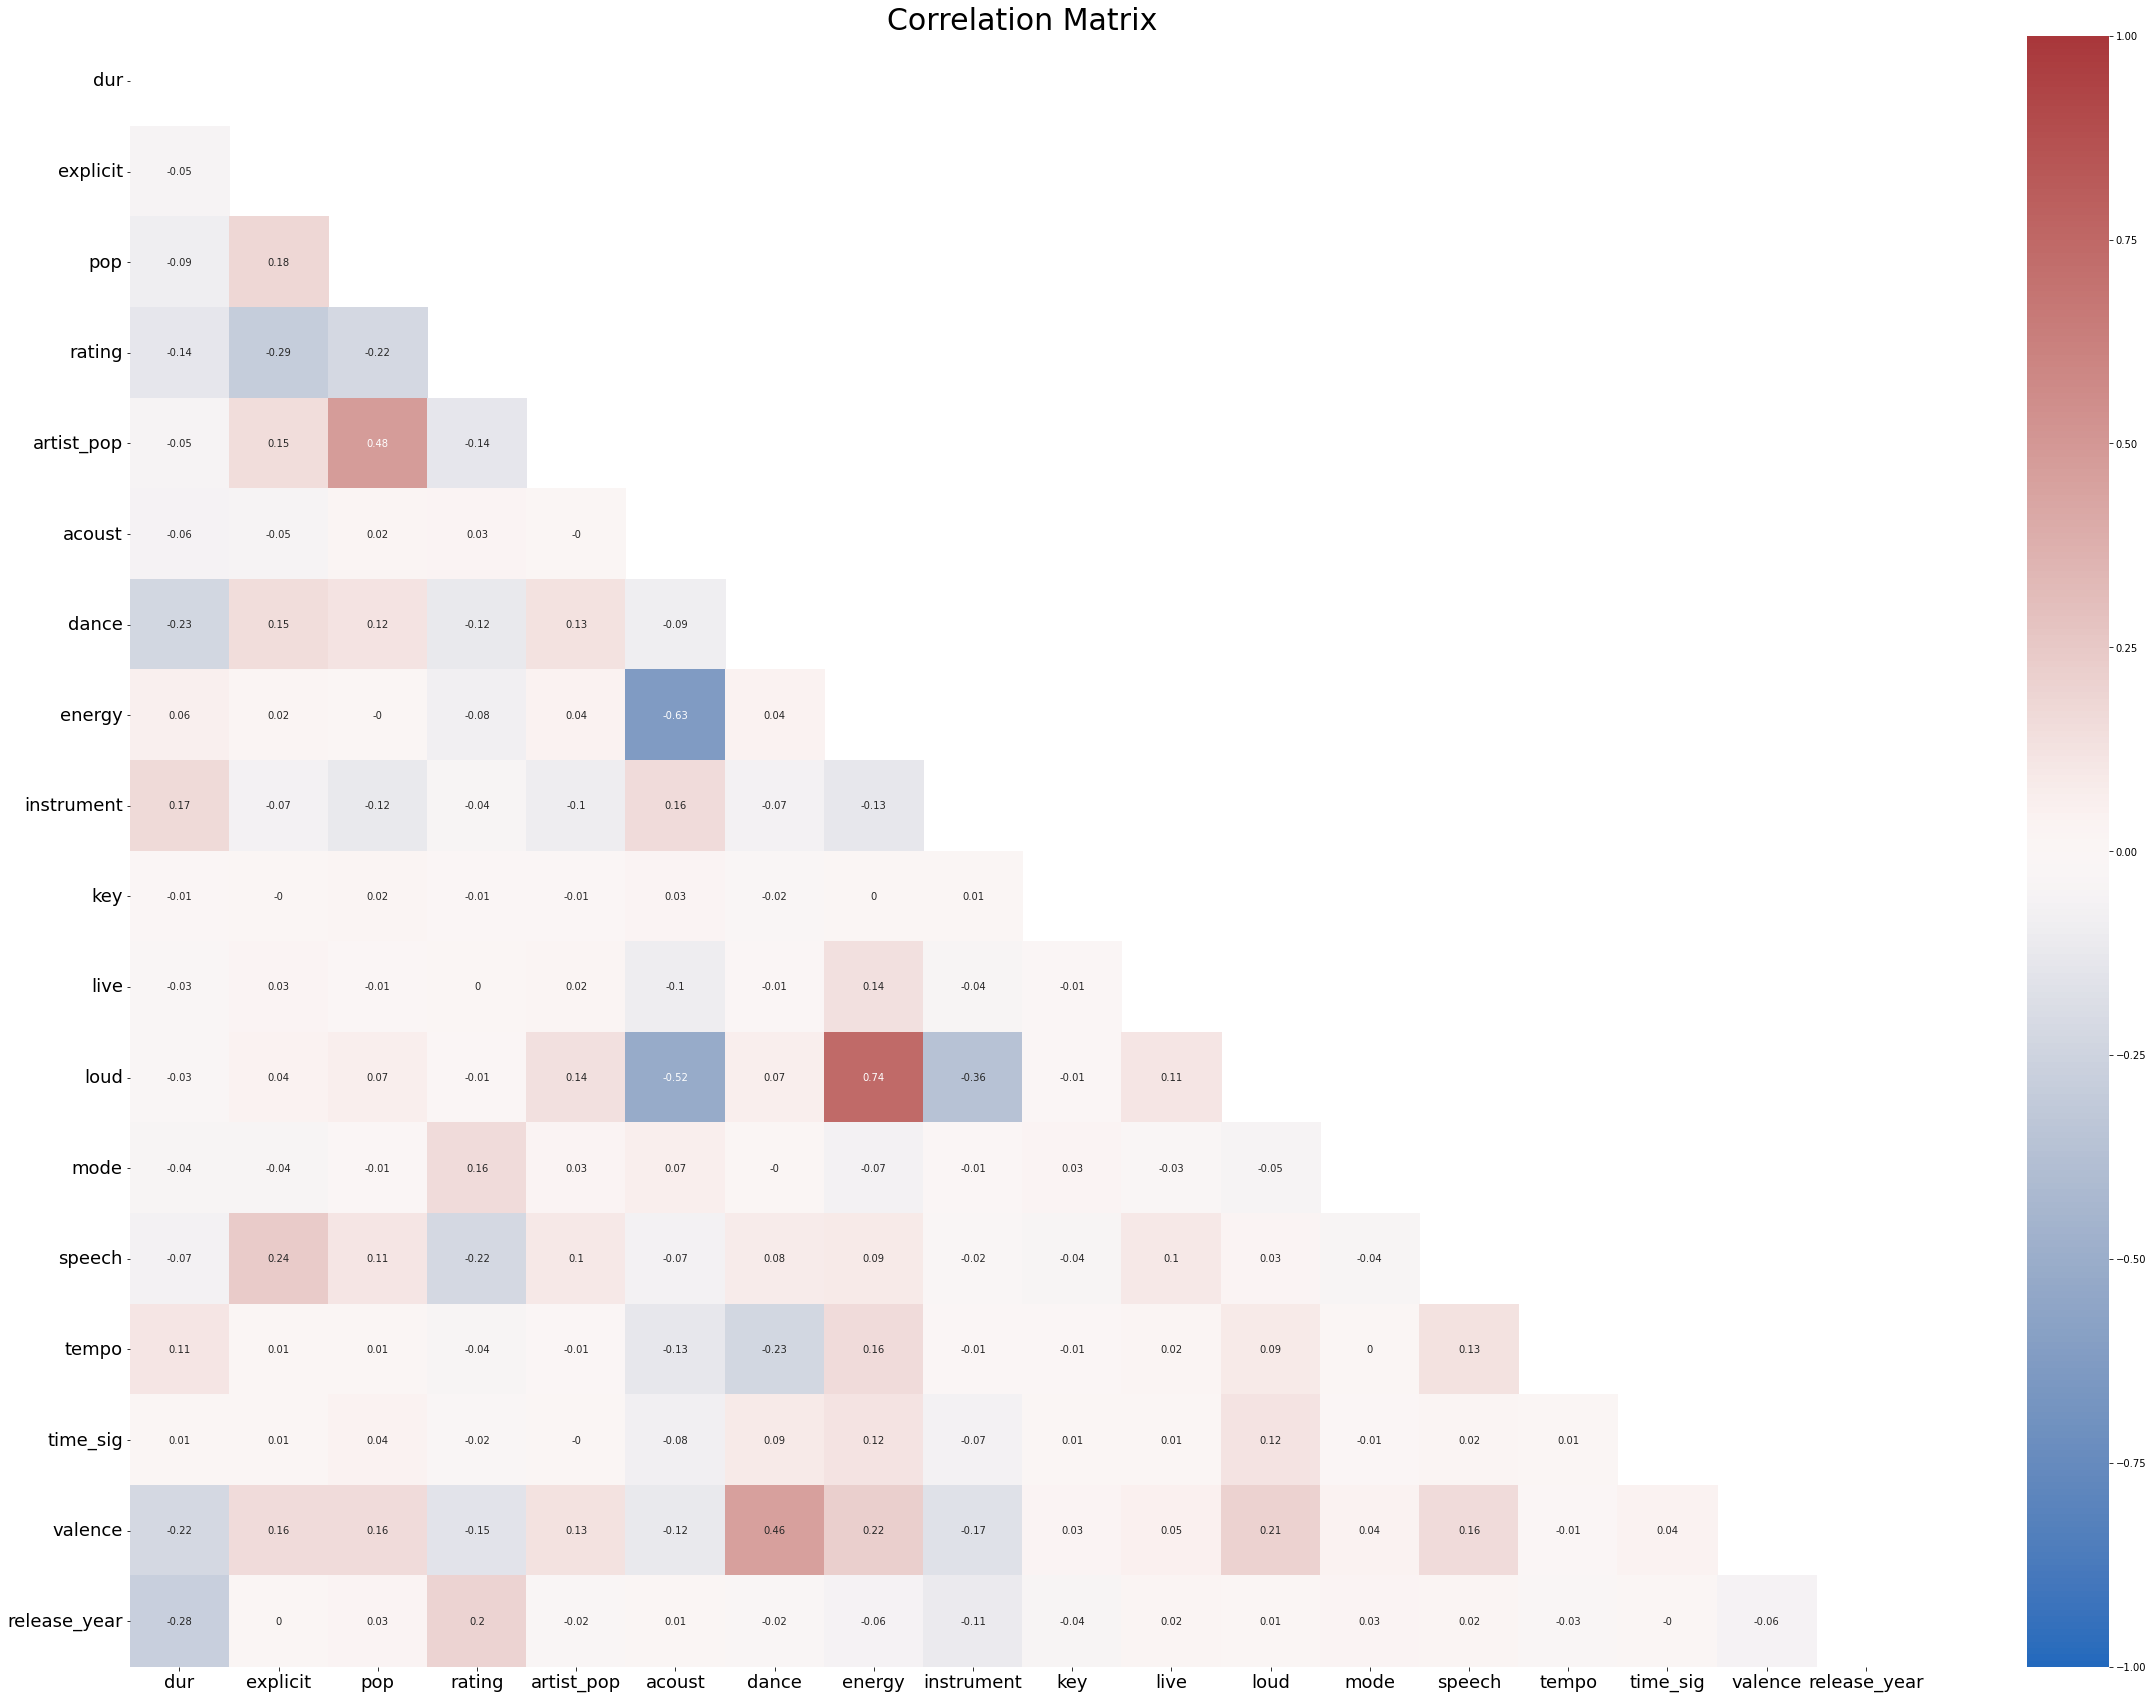

In [ ]:
matrix = song_traits.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(40, 30))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18, rotation='horizontal')
plt.title('Correlation Matrix', fontsize=30)
plt.show()

In [ ]:
corrs = df.corr()
test = corrs[['rating']]
fig = px.imshow(test.drop('rating'), text_auto=False, aspect="auto",
               color_continuous_scale='RdYlGn',
               color_continuous_midpoint=0)
fig.show()

# Model Analysis
These segments explore model evaluation metrics and predictions

### Model Predictions Histogram
This histogram plots the predicted song rating for all of the songs from the input playlists.  This plot can be used to visualize what is the best predicted model rating value to separate your favorites playlist songs from the rest.  You can then use this value as the model prediction threshold to get more accurate song recommendations (set song_threshold in config).<br><br>

A number is assigned for each input playlist, whereby each song from the first playlist will be given a rating of 0.  The songs from the next playlist have a rating of 1.  And so on for the rest of the playlists.<br>

The bars on this histogram are colored by the their true rating label and their x-axis values are the model's predicted rating value.

## Model Params and Visualizations

In [ ]:
vis_preds(X_train, y_train, model, 'Training Data')
vis_preds(X_test, y_test, model, 'Validation Data')
vis_preds(None, None, model, 'Recommended Songs', pred_songs=True)






### Model Training History
This interactive visualization tool helps to see how the model evaluation metrics changed across epochs.  Each plot will separate model metrics between the training and validation portion of the dataset.  Our early stopping callback will stop the model from running if the performance metric doesn't improve over a few epochs and will restore the best model's weights

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs